In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import shutil
from pathlib import Path
from yahooquery import Ticker

# STOCK = "aapl"
# DATASET_PATH = Path(".qlib")
# REG_DIR = DATASET_PATH / Path("us")
# STOCK_PATH = REG_DIR / Path(f"{STOCK}.csv")

# if os.path.exists(DATASET_PATH):
#     shutil.rmtree(DATASET_PATH)
# os.makedirs(REG_DIR)

# aapl = Ticker("aapl")
# price = aapl.history(period="max")

# price.to_csv(STOCK_PATH)

In [3]:
# !python scripts/dump_bin.py dump_all --csv_path .qlib/us --qlib_dir .qlib/qlib_data --include_fields open,close,high,low,volume,adjclose

In [4]:
import qlib
from qlib.data import D
from qlib.constant import REG_CN, REG_US

start_date = "2012-01-01"
end_date = "2022-12-31"

target="Adj_Close"

fields_dict = {
    "Adj_Close": "$adjclose",
    #"Open": "$open",
    #"Close": "$close",
    #"Open_Close_Diff": "$open-$close",
    #"High": "$high",
    #"Low": "$low",
    #"Factor": "$adjclose/$close",
    #"Volume": "$volume",
    #"High_Low_Diff": "$high-$low",
    # "Open_MA3": "Mean($open, 3)",
    # "Open_MA5": "Mean($open, 5)",
    # "Open_MA10": "Mean($open, 10)",
    # "Open_MA20": "Mean($open, 20)",
    # "Open_EMA3": "EMA($open, 3)",
    # "Open_EMA5": "EMA($open, 5)",
    # "Open_EMA10": "EMA($open, 10)",
    # "Open_EMA20": "EMA($open, 20)",
    # "Open_WMA3": "WMA($open, 3)",
    # "Open_WMA5": "WMA($open, 5)",
    # "Open_WMA10": "WMA($open, 10)",
    # "Open_WMA20": "WMA($open, 20)",
    # "Close_MA3": "Mean($close, 3)",
    # "Close_MA5": "Mean($close, 5)",
    # "Close_MA10": "Mean($close, 10)",
    # "Close_MA20": "Mean($close, 20)",
    # "Close_EMA3": "EMA($close, 3)",
    # "Close_EMA5": "EMA($close, 5)",
    # "Close_EMA10": "EMA($close, 10)",
    # "Close_EMA20": "EMA($close, 20)",
    # "Close_WMA3": "WMA($close, 3)",
    # "Close_WMA5": "WMA($close, 5)",
    # "Close_WMA10": "WMA($close, 10)",
    # "Close_WMA20": "WMA($close, 20)",
    #"MACD": "(EMA($close, 12) - EMA($close, 26))/$close - EMA((EMA($close, 12) - EMA($close, 26))/$close, 9)/$close",
    # "Residual": "$adjclose-Ref($adjclose,1)",
}

provider_uri = ".qlib/qlib_data"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_US)
instruments = ["AAPL"]
fields = fields_dict.values()
len_feats = len(fields_dict)
target_index = list(fields_dict.keys()).index(target)
dataset = D.features(
    instruments, fields, start_time=start_date, end_time=end_date, freq="day"
).rename(columns={v: k for k, v in fields_dict.items()})
print(len(dataset))
dataset.isna().sum().sum()

[360794:MainThread](2023-11-22 00:57:31,299) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[360794:MainThread](2023-11-22 00:57:31,458) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[360794:MainThread](2023-11-22 00:57:31,459) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/mnt/Yeh/Dataset/ziyang/A3/.qlib/qlib_data')}


2768


0

In [5]:
dataset = dataset.loc["AAPL"]

In [6]:
from sklearn.model_selection import train_test_split

ratio = 0.8
train_data, test_data = train_test_split(dataset, train_size=ratio, shuffle=False)
train_data.shape, test_data.shape

((2214, 1), (554, 1))

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(train_data)
df_for_testing_scaled=scaler.transform(test_data)

In [8]:
import numpy as np

def createXY(dataset,n_past, index=0):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, :])
            dataY.append(dataset[i,index])
    return np.array(dataX),np.array(dataY)        

In [9]:
train_steps = 50
test_steps = 30

trainX,trainY=createXY(df_for_training_scaled,train_steps,index=target_index)
testX,testY=createXY(df_for_testing_scaled,test_steps,index=target_index)
train_shape = trainX.shape[1:]
trainX.shape,trainY.shape,testX.shape,testY.shape

((2164, 50, 1), (2164,), (524, 30, 1), (524,))

In [10]:
import keras_core as keras
from keras_core.layers import *
def rnn_model(optimizer,shape,dropout=0.2):
    grid_model = keras.Sequential()
    grid_model.add(LSTM(64,return_sequences=True,input_shape=shape))
    grid_model.add(LSTM(64))
    grid_model.add(Dropout(dropout))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

rnn = rnn_model('adam',train_shape)

history = rnn.fit(trainX,trainY,batch_size=256,epochs=15)

Using PyTorch backend.
Epoch 1/15


/mnt/Yeh/Dataset/ziyang/miniconda3/envs/keras/lib/python3.10/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0346
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0038
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0015
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0012
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 8.4481e-04
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 9.1662e-04
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 9.4998e-04
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 8.4478e-04
Epoch 9/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 9.0211e-04
Epoch 10/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 7.8805e-04
Epoch 11/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 7.6769e-04
Epoch 12/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 6.7462e-04
Epoch 13/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.4259e-04
Epoch 14/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.6750e-04
Epoch 15/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 7.5698e-04


In [11]:
prediction=rnn.predict(testX)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [12]:
prediction_copies_array = np.repeat(prediction,len_feats, axis=-1)
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),len_feats)))[:,0]

In [13]:
original_copies_array = np.repeat(testY,len_feats, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),len_feats)))[:,0]

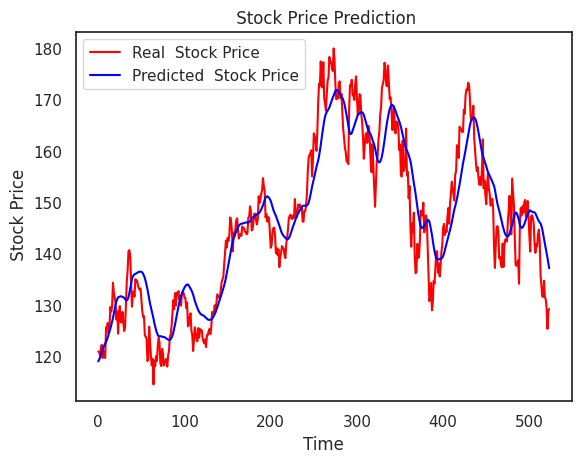

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [15]:
y_true = original
y_pred = pred
mse = keras.losses.MeanSquaredError()
mse(y_true, y_pred).cpu().numpy()

array(36.562767, dtype=float32)